**Jargon_Vocabulary**

**seq_len** : The maximum length of the input sequence

**d_model** : The size of input_embedding[vector] usually 512

**vocab_size** : The number of words in your vocabulary

**alpha** : multiplier when normalizing the data

**bias** : additive part when normalizing the data

**epsilon** : a small value for numerical stability when normalizing the data

**h** : h is the number of heads in which you want to divide Q , K , V matrices. The division would be perform on the d_model that is the embed_vector of 512 and have the whole seq_length.

**Encoder_masking** : masking is performed in the multihead attention module in order to mask the relationship b/w certian tokens/words. For example we have to pad the tokens in order to meet up with the seq_len so we do not want inoder to be part of context. So we replace the value with really small number so when we apply softmax it is zeroed out.

**Deocder_masking** : This is masking is termed as causal maksing. So the predicted words can only see the words that have already being predicted and can not have a context of future words/tokens

In [ ]:
import torch
import torch.nn as nn
import math

class InputEmbeddings(nn.Module):

  def __init__(self,d_model : int, vocab_size : int):
    super().__init__()

    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self,x):
    return self.embedding(x) * math.sqrt(self.d_model) #in the paper they multiply the embedding by sqrt(d_model)

class Positional_Encoding(nn.Module):

  def __init__(self,d_model : int, seq_len : int, dropout : float):
    super().__init__()

    self.d_model = d_model
    self.seq_len = seq_len
    self.dropout = nn.Dropout(dropout)

    #creating a matrix of seq_len * d_model for positional encoding
    positional_encoding = torch.zeros(seq_len , d_model)

    #create a vector of seq_len , 1
    position = torch.arrange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2)).float() * ((-math.log(10000.0)/ d_model))

    #Apply sin() to even position
    positional_encoding[:, 0::2] = torch.sin(position * div_term)
    #Apply cos() on the odd position
    positional_encoding[:, 1::2] = torch.cos(position * div_term)

    #adding a batch dimension
    positional_encoding = positional_encoding.unsqueeze(0) #(1, seq_len, d_model)

    #registering this so it would be saved when we save the state of the model as PE would not change
    self.register_buffer('pe',positional_encoding)

  def forward(self,x):

    x = x + (self.pe[ :, :x.shape[1], :]).requires_grad_(False) # we dont want to backprop as we dont want to learn the PE

    return self.dropout(x)



**Layer Normalization**

If you have a batchsize of 3 items. Its going to normalize the data individually batch by batch. There are 2 variables introduce named as beta and gamma where gamma being the multiplicative part and beta be the additive part. There are also other terminologies used such as alhpa and bias etc.

We also introduce a small variable termed as epsilon for numerical stability so when normalizing the data if the variance become too small close to zero the value would become really large hence leading to explode the data.

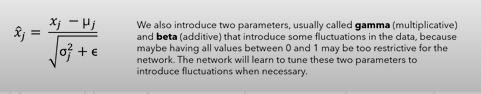

In [ ]:
class LayerNormalization(nn.Module):

  def __init__(self, eps : float = 10**-6 ):
    super().__init__()

    self.eps = eps
    self.alpha = nn.Parameter(torch.ones(1)) #multiplier
    self.bias = nn.Parameter(torch.zeros(1)) #added

  def forward(self,x):
    mean = x.mean( dim = -1, keepdim = True)
    std = x.std( dim = -1 , keepdim = True)

    return self.alpha * ( x - mean ) / (std + self.eps ) + self.bias

In [ ]:
class FeedForwardBlock(nn.Module):

  def __init__(self, d_model : int, dff : int, dropout : float):
    super().__init__()

    self.lin1 = nn.Linear(d_model, dff)
    self.dropout = nn.Dropout(dropout)
    self.lin2 = nn.Linear(dff, d_model)

  def forward(self, x):
    # (batch_size, seq_len, d_model) --> (batch_size, seq_len, dff) --> (batch_size, seq_len, d_model)

    return self.lin2(self.dropout(torch.relu(self.lin1(x))))

**Multi Head Attention**

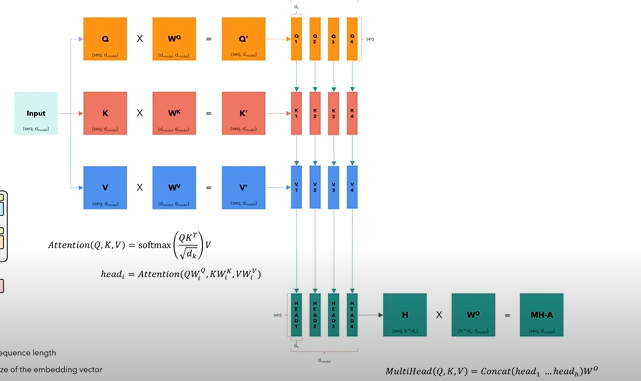

In [ ]:
class MultiHeadAttentionModule(nn.Module):

  def __init__(self, d_model : int, h : int, dropout : float):
    super().__init__()

    assert d_model % h == 0 , 'd_model should be divisible by number of heads'

    self.d_k = d_model // h

    self.WQ = nn.Linear(d_model, d_model)
    self.WK = nn.Linear(d_model, d_model)
    self.WV = nn.Linear(d_model, d_model)

    self.WO = nn.Linear()

    @staticmethod
    def attention(query, key, value, mask, dropout : nn.Dropout):
      d_k = query.shape[-1]

      #(Batch, h, seq_len, d_model) ---> (Batch, h, seq_len, seq_len)
      attention_scores = (query @ key.transpose(-2, -1))/math.sqrt(d_k)

      if mask is not None:
        attention_scores.masked_fill( mask == 0, -1e9)

      attention_scores = attention_scores.softmax(dim = -1)

      if dropout is not None:
        attention_scores = dropout(attention_scores)

      self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask):
      query = self.WQ(q)
      key = self.Wk(k)
      value = self.WV(v)

      # (batch, seq_len, d_model) ---> (batch, seq_len , h , d_k) --tranpose--> (batch, h , seq_len, d_k) --> so for item[h] --> (seq_len, d_k)
      query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2)
      key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2)
      value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2)

      x , self_attention_scores = MultiHeadAttentionModule.attention(query, key, value, self.dropout)
      #(batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
      x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.d_k * h)

      return self.WO(x)

**Residual Connection**

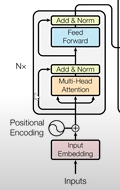

In [ ]:
class ResidualConnection(nn.Module):

  def __init__(self, dropout : float):
    super().__init__()

    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

    def forward(self, x, sublayer):
      #sublayer is the previous layer which I am guessing is Multiheadattention and the feedwardlayer

      return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self, self_attention_block : MultiHeadAttentionModule, feed_forward : FeedForwardBlock, dropout : float):
    super().__init__()

    self.self_attention_block = self_attention_block
    self.feed_forward = feed_forward
    self.dropout = dropout
    self.residual_connection_1 = ResidualConnection(dropout)
    self.residual_connection_2 = ResidualConnection(dropout)

  def forward(self, x, src_mask):

    x = x + self.residual_connection_1(x, self.self_attention_block(x, x, x, src_mask))
    x = x + self.residual_connection_2(x, self.feed_forward(x))
    return x

In [ ]:
class Encoder(nn.Module):

  def __init__(self, layers : nn.ModuleList): # There are usually 6 layers of the encoder
    super().__init__()

    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, src_mask):

    for layer in self.layers:
      x = layer(x, src_mask)

    return self.norm(x)


**Decoder Block**

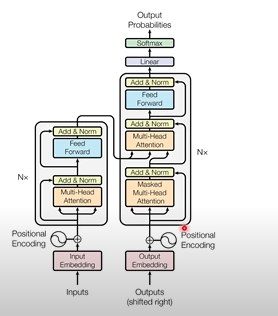

In [ ]:
class DecoderBlock(nn.Module):

  def __init__(self, self_attention_block : MultiHeadAttentionModule, cross_attention_block : MultiHeadAttentionModule, feed_forward : FeedForwardBlock, dropout : float):
    super().__init__()

    self.self_attention_block = self_attention_block
    self.feed_forward = feed_forward
    self.cross_attention = cross_attention_block

    self.residual_connection_1 = ResidualConnection(dropout)
    self.residual_connection_2 = ResidualConnection(dropout)
    self.residual_connection_3 = ResidualConnection(dropout)

  def forward(self, x, encoder_output, encoder_mask, decoder_mask):

    x = self.residual_connection_1(x, self.self_attention_block(x, x, x, decoder_mask))
    x = self.residual_connection_2(x, self.cross_attention_block(x, encoder_output, encoder_output, encoder_mask))
    x = self.residual_connection_3(x, self.feed_forward(x))



In [ ]:
class Decoder(nn.Module):
  def __init__(self, layers : nn.ModuleList):
    super().__init__()

    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self, x, encoder_output, encoder_mask, decoder_mask):

    for layer in self.layers:
      x =  layer(x, encoder_output, encoder_mask, decoder_mask)

    return self.norm(x)

In [ ]:
class ProjectionLayer(nn.Module):

  def __init__(self, d_model : int, vocab_size : int):
    super().__init__()

    self.projection = nn.Linear(d_model, vocab_size)

  def forward(self, x):

    return torch.log_softmax(self.proj(x), dim = -1)

In [ ]:
class Transformer(nn.Module):

  def __init__(self, encoder: Encoder, decoder: Decoder, source_embedding: InputEmbeddings, target_embedding: InputEmbeddings, source_pe: Positional_Encoding, target_pe,  projection: ProjectionLayer):
    super().__init__()

    self.encoder = encoder
    self.source_embedding = source_embedding
    self.source_pe = source_pe

    self.decoder = decoder
    self.target_embedding = target_embedding
    self.target_pe = target_pe

    self.projection = projection

  def encode(self, source, source_mask):
    src_emb = self.target_embedding(source)
    src_emb_pe = self.source_pe(src_emb)

    return self.encoder(src_emb_pe, source_mask)

  def decode(self, encoder_output, encoder_mask, target, decoder_mask):
    target_emb = self.target_embedding(target)
    target_emb_pe = self.target_pe(target_emb)

    return self.decoder(target_emb_pe, encoder_output, encoder_mask, decoder_mask)

  def projection(self, x):
    return self.projection(x)


In [ ]:
def build_transformer(src_vocab_size: int, target_vocab_size : int, src_seq_len : int, target_seq_len : int, d_model : int = 512, h : int = 8, dff : int = 2048, N : int = 6, dropout: float = 0.1):
  #creating embeddings
  src_emb = InputEmbeddings(d_model, src_vocab_size)
  tgt_emb = InputEmbeddings(d_model, target_vocab_size)

  #create postional encodings
  src_pe = Positional_Encoding(d_model, src_seq_len, dropout)
  tgt_pe = Positional_Encoding(d_model, target_seq_len, dropout)

  #Create the encoder blocks
  encoder_blocks = []
  for _ in range(N):
    self_attention = MultiHeadAttentionModule(d_model, h, dropout)
    feed_forward = FeedForwardBlock(d_model, dff, dropout)

    encoder_blocks.append(EncoderBlock(self_attention, feed_forward, dropout))

  #create decoder blocks
  decoder_blocks = []
  for _ in range(N):
    self_attention = MultiHeadAttentionModule(d_model, h, dropout)
    cross_attention = MultiHeadAttentionModule(d_model, h , dropout)
    feed_forward = FeedForwardBlock(d_model, dff, dropout)

    decoder_blocks.append(DecoderBlock(self_attention, cross_attention, feed_forward, dropout))

  #creating projection layer
  proj_layer = ProjectionLayer(d_model, target_vocab_size)

  #Creating Encoder
  encoder = Encoder(nn.ModuleList(encoder_blocks))

  #Creating Decoder
  decoder = Decoder(nn.ModuleList(decoder_blocks))

  transformer = Transformer(encoder, decoder, src_emb, tgt_emb, src_pe, tgt_pe, proj_layer)

  #Initlize the parameters
  for p in transformer.paramters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return transformer


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [ ]:
!pip install pathlib

**Train.py**

In [ ]:
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from pathlib import Path

def get_all_sentences(ds, lang):
  for item in ds:
    yield item['translation'][lang]

In [ ]:
import os
def get_or_build_tokenizer(config, ds, lang):
  tokenizer_path = Path(config['tokenizer_file'].format(lang))

  if not Path.exists(tokenizer_path):
    tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]'))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_token = ['[UNK]', '[PAD]', '[SOS]', '[EOS]'], min_frequency=2)
    tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
    tokenizer.save(str(tokenizer_path))

**Dataset**

In [ ]:
from torch.utils.data import Dataset
class BilingualDataset(Dataset):
  def __init__(self, ds, src_lang, tgt_lang, src_tokenizer, tgt_tokenizer, seq_len : int):
    super().__init__()

    self.ds = ds
    self.tokenizer_src = src_tokenizer
    self.tokenizer_tgt = tgt_tokenizer
    self.src_lang = src_lang
    self.tgt_lang = tgt_lang

    self.sos_token = torch.Tensor([src_tokenizer.token_to_id(['[SOS]'])], dtype=torch.int64)
    self.eos_token = torch.Tensor([src_tokenizer.token_to_id(['[EOS]'])], dtype=torch.int64)
    self.pad_token = torch.Tensor([src_tokenizer.token_to_id(['[PAD]'])], dtype=torch.int64)

  def __len__(self):
    return len(self.ds)

  def __getitem__(self, index):
    src_tgt_pair = self.ds[index]
    src_text = src_tgt_pair['translation'][self.src_lang]
    tgt_text = src_tgt_pair['translation'][self.tgt_lang]

    enc_input_tokens = self.tokenizer_src.encoder(src_text).ids #where it appears in the vocabulary
    dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

    enc_num_padd_tokens = self.seq_len - len(enc_input_tokens) - 2 # sos and eos
    dec_num_padd_tokens = self.seql_len - len(dec_input_tokens) - 1 # only eos

    assert enc_num_padd_tokens < 0 or dec_num_padd_tokens < 0

    encoder_input = {
        self.sos_token,
        torch.tensor(enc_input_tokens, dtype=torch.int64),
        self.eos_token,
        torch.tensor([self.pad_token] * enc_num_padd_tokens, dtype=torch.int64)
    }

    decoder_input = {
        self.sos_token,
        torch.tensor(enc_input_tokens, dtype=torch.int64),
        torch.tensor([self.pad_token] * dec_num_padd_tokens, dtype=torch.int64)
    }

    label = torch.cat(
        [
            torch.tensor(dec_input_tokens, dtype=torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * dec_num_padd_tokens, dtype=torch.int64)
        ]
    )

    return {
        'encoder_input': encoder_input, #(Seq_len)
        'decoder_input': decoder_input,
        'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0),# (1, 1, seq_len)
        'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0) & causal_mask(decoder_input.size(0)),
        'label': label,
        'src_text': src_text,
        'tgt_text': tgt_text,
        'tgt': label
    }

def causal_mask(size):
  mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int)

  return mask == 0

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
def get_ds(config):
  ds_raw = load_dataset('opus_book', f'{config["lang_src"]}-{config["lang_tgt"]}', split='train')

  #Build the tokenizer
  tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])
  tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lnag_tgt'])

  #keep 90% training and 10% for validation
  train_ds_size = int(0.9 * len(ds_raw))
  val_ds_size = len(ds_raw) - train_ds_size
  train_ds_raw , val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

  train_ds = BilingualDataset(train_ds_raw,config['lang_src'], config['lang_tgt'], tokenizer_src, tokenizer_tgt, config['seq_len'])
  val_ds = BilingualDataset(val_ds_raw,config['lang_src'], config['lang_tgt'], tokenizer_src, tokenizer_tgt, config['seq_len'])

  max_len_src = 0
  max_len_tgt = 0

  for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][config['src_lang']])
    tgt_ids = tokenizer_tgt.encode(item['translation'][config['tgt_lang']])

    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt =max(max_len_tgt, len(tgt_ids))

  print('Max lenght of input sentence: ',max_len_src)
  print('Max length of tgt sentence:', max_len_tgt)

  train_data_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
  val_data_loader = DataLoader(val_ds, batch_size=1, shuffle=True)

  return train_data_loader , val_data_loader, tokenizer_src, tokenizer_tgt

In [ ]:
def get_model(config, vocab_src_len, vocab_tgt_len):
  model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])

def get_config():
  return {
      'batch_size': 8,
      'num_epochs': 20,
      'seq_len': 350,
      'lr': 1e-4,
      'd_model': 512,
      'lang_src': 'en',
      'lang_tgt': 'it',
      'model_folder': 'weights',
      'model_basename': 'tmodel_',
      'preload': None,
      'tokenizer_file': 'tokenizer_{0}.json',
      'experiment_name': 'runs/tmodel,'

  }

In [ ]:
def train_model(config):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Running on device: ',device)


  optimizer = torch.optim.Adam(model.paramters(), lr=config['lr'], eps=1e-9)

  train_dataloader, val_dataloader,  tokenizer_src, tokenizer_tgt = get_ds(config)

  model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

  loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]')).to(device)

  for epoch in range(config['num_epochs']):

    model.train()

    batch_iterator = train_dataloader

    for batch in batch_iterator:

      encoder_input = batch['encoder_input'].to(device) # (B, Seqlen)
      decoder_input = batch['decoder_input'].to(device) # (B, Seqlen)
      encoder_mask = batch['encoder_mask'].to(device)
      decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seqlen, seqlen)

      encoder_output = model.encode(encoder_input, encoder_mask) # (B, seqlen, dmodel)
      decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
      proj_output = model.project(decoder_output) # (B, seqLen, tgt_vocab_size)

      label = batch['label'].to(device)# (B, seqlen)

      #(B, seqlen, tgt_vocab_size) --> (B * seqlen, tgt_vocab_size)
      loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

    model_filename = 'torch_model'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    },model_filename)

In [ ]:
#we need the output of the encoder only once no need to compute it again and again
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
  sos_idx = tokenizer_tgt.token_to_id('[SOS]')
  eos_idx = tokenizer_tgt.token_to_id('[EOS]')

  encoder_output = model.encode(source, source_mask)

  decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)

  while True:

    if decoder_input.size(1) == max_len:
      break

    decoder_mask = causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)

    out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

    #we only need to project the last predicted token because the previous one might already be projected
    prob = model.project(out[:, -1])

    _, next_token = torch.max(prob, dim=1)

    decoder_input = torch.cat([decoder_input, torch.empty(1,1).type_as(source).fill_(next_token.item()).to(device)], dim=1)

    if next_token == eos_idx:
      break

def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device):

  model.eval()
  count = 0

  source_text = []
  predicted_text = []
  expected_text = []

  with torch.no_grad():
    for batch in validation_ds:
      count += 1
      encoder_input = batch['encoder_input'].to(device)
      encoder_mask = batch['encoder_mask'].to(device)

      model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

      source_text = batch['src_text'][0]
      target_text = batch['tgt_text'][0]

      model_out_text = tokenizer_tgt.deocde(model_out.detach().cpu().numpy())

      source_text.append(source_text)
      expected_text.append(target_text)
      predicted_text.append(model_out_text)
